<a href="https://colab.research.google.com/github/deqg/deq/blob/main/InProgress_EigenGame_Laplacian1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1d example of the Dirichlet eigenvalue problem

## The problem

$$-u''(x) = \lambda u(x)$$
$$u(0)=u(1)=0$$

To find the solution to the above problem using Mathematica:

https://www.wolframalpha.com/input?i=Solve+-u%27%27%28x%29+%3D+lambda+u%28x%29%2C+u%280%29%3Du%281%29%3D0

gives the solution

$$u(x) = c \sin(\sqrt{\lambda} x)$$
$$\lambda = (n\pi)^2,n=1,2,\cdots$$

The eigenvalues form an increasing sequence.

Refs:

[1] https://en.wikipedia.org/wiki/Dirichlet_eigenvalue

[2] https://www.math.ucdavis.edu/~saito/tutorials/nifs13.pdf

[3] https://faculty.math.illinois.edu/~laugesen/595Lectures.pdf (Chapter 2, 32)



#Theoretical formulation
The eigenvalues could be find using
$$\lambda_1 = \inf_{\int_{\Omega}u^2 dx =1}\int_\Omega |\nabla u|^2 dx$$
$$\lambda_2 = \inf_{\int_{\Omega}u^2 dx=1, \int_{\Omega} u \cdot u_1 dx = 0}\int_\Omega |\nabla u|^2 dx$$
$$\ldots$$
$$\lambda_k =\inf_{\int_\Omega u^2 dx = 1, \int_{\Omega} u\cdot u_sdx = 0, s=1,\ldots,k-1}\int_\Omega |\nabla u|^2 dx$$

Instead of using the orthogonal constraints, we can use the Gram-Schmidt process to define the orthogonal space. For example, any space
$V_1 = \{u:\int_{\Omega} u \cdot u_1 dx = 0\}$
can be represented by
$$u-\frac{\langle u,u_1\rangle}{\langle u_1,u_1\rangle} u_1$$
($\langle f,g \rangle=\int_\Omega fg dx$ is the inner product)
this can be also rewritten using $\langle \nabla u,\nabla u_1 \rangle = \langle u, (-\Delta u_1)\rangle = \langle u,\lambda u_1\rangle$ (the first equality is due to integration-by-parts, the second equality is due to $u_1$ being the first eigenfunction) as
$$u-\frac{\langle \nabla u,\nabla u_1\rangle}{\langle \nabla u_1,\nabla u_1\rangle} u_1$$
Hence $\lambda_2$ can be solved by
$$\lambda_2 = \inf_{\int_\Omega \left(u-\frac{\langle \nabla u,\nabla u_1\rangle}{\langle \nabla u_1,\nabla u_1\rangle} u_1\right)^2 dx = 1}\int_\Omega \left(\nabla u-\frac{\langle \nabla u,\nabla u_1\rangle}{\langle \nabla u_1,\nabla u_1\rangle} \nabla u_1\right)^2dx$$
and this equals
$$\lambda_2 = \inf_{\int_\Omega \left(u-\frac{\langle \nabla u,\nabla u_1\rangle}{\langle \nabla u_1,\nabla u_1\rangle} u_1\right)^2 dx = 1}\langle \nabla u,\nabla u\rangle -\frac{(\langle \nabla u,\nabla u_1\rangle)^2}{\langle \nabla u_1,\nabla u_1\rangle} $$
Simply, one can find the orthogonal space $V_k=\{u: \langle u,u_1\rangle =\ldots=\langle u_{k-1}\rangle =0\}$ represented by
$$u-\sum_{j=1}^{k-1} \frac{\langle \nabla u,\nabla u_j\rangle}{\langle \nabla u_j,\nabla u_j\rangle} u_j$$


## The computation of the Dirichlet eigenvalue problem
A neural network is constructed to represent the function $u_\theta(x)$ with $\theta$ being the parameters of the neural network.

The minimization procedure: following the EigenGame paper (https://arxiv.org/pdf/2010.00554.pdf)

$\lambda_1 = \min_{\theta}\frac{\int_0^1 (u_{\theta}')^2 dx}{\int_0^1 u_\theta^2 dx}$

$\lambda_2 = \min_{\theta} \frac{\int_0^1 (u'_\theta)^2 dx}{\int_0^1 v_\theta^2 dx} - \frac{(\int_{0}^1 u_{\theta}' u_1' ds)^2}{\int_0^1 (u_1')^2 dx \cdot \int_0^1 v_\theta^2 dx}$
where $v_\theta = u_\theta - \frac{\langle u_\theta',u_1'\rangle}{\langle u_1',u_1'\rangle}u_1$

>in order to impose the constraint $u(0)=u(1)=0$, we take
$$u(x) = N(x) (1-e^{-x})(1-e^{-(x-1)})$$
with $N(x)$ represented by the neural network

>the integration is evaluated using Mento-Carlo integration
$$\int_0^1 u(x) dx = \frac{1}{N} \sum_{i=1}^N u(x_i)$$
with $x_i$ drawing from uniform distribution $U[0,1]$.

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import matplotlib.pyplot as plt

List the first three eigenvectors and eigenvalues

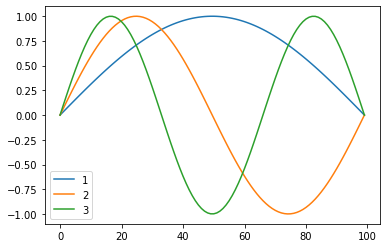

In [ ]:

x = jnp.linspace(0,1,100)
u1 = jnp.sin(jnp.pi*x)
u2 = jnp.sin(2*jnp.pi*x)
u3 = jnp.sin(3*jnp.pi*x)

plt.plot(u1)
plt.plot(u2)
plt.plot(u3)
plt.legend(['1','2','3'])

In [ ]:
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# layer_sizes = [1, 1024, 1024, 1]
layer_sizes = [1, 256, 256, 1]
step_size = 1e-2
params = init_network_params(layer_sizes, random.PRNGKey(0))


In [ ]:
def relu(x):
  return jnp.maximum(0, x)
def tanh(x):
  return jnp.tanh(x)

def predict(params, x):
  activations = x
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = tanh(outputs)

  final_w, final_b = params[-1]
  output = jnp.dot(final_w, activations) + final_b
  return output* (1.-jnp.exp(-(x))) * (1.-jnp.exp(-(x-1)))


In [ ]:
def predict_one(params,x):
  return predict(params,x)[0]
# creating new function, uses other functions
batched_predict = vmap(predict_one, in_axes=(None, 0))
# random_flattened_image = random.normal(random.PRNGKey(1), (125,1))
# preds = batched_predict(params, random_flattened_image)
# preds.shape
batched_grad = vmap(grad(predict_one,argnums=1), in_axes=(None, 0))


In [ ]:
def loss(params,x):
  y = batched_grad(params,x)
  z = batched_predict(params,x)
  return jnp.mean(y*y)/jnp.mean(z*z)

In [ ]:
@jit
def update(params, x):
  grads = grad(loss)(params, x)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


In [ ]:
for epoch in range(3000):
    x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
    for _ in range(1):
      params = update(params, x)


In [ ]:
xx = jnp.linspace(0,1,10000)
xx = xx.reshape((10000,1))
zz = batched_predict(params,xx)
yy = batched_grad(params,xx)
print(jnp.mean(yy*yy)/jnp.mean(zz*zz))

9.908104


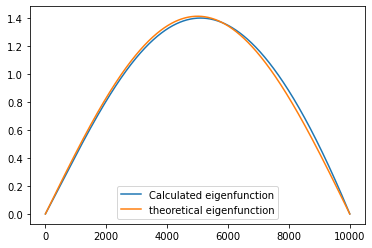

In [ ]:
import matplotlib.pyplot as plt

plt.plot(-zz/jnp.sqrt(jnp.mean(zz**2)))
plt.plot(jnp.sin(jnp.pi*xx)*jnp.sqrt(2))
plt.legend(['Calculated eigenfunction','theoretical eigenfunction'])

Calculate the second eigenfunction, note that $v=u-\frac{\langle u',u_1'\rangle}{\langle u_1',u_1'\rangle}u_1$ is the eigenfunction ( $u$ is not)

In [ ]:
params2 = init_network_params(layer_sizes, random.PRNGKey(0))
def loss2(params2,params,x):
  y = batched_grad(params,x)
  z = batched_predict(params,x)
  y2 = batched_grad(params2,x)
  z2 = batched_predict(params2,x)
  dv = y2 - jnp.mean(y2*y)/jnp.mean(y*y)*y
  v = jnp.mean((z2-z*jnp.mean(y2*y)/jnp.mean(y*y))**2)

  return jnp.mean(dv**2)/v

In [ ]:
@jit
def update2(params2,params, x):
  grads = grad(loss2)(params2, params, x)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params2, grads)]


In [ ]:
los = []
for epoch in range(3000):
    x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
    for _ in range(1):
      params2 = update2(params2, params, x)
    if epoch % 100==0:
      los.append(loss2(params2,params,x))

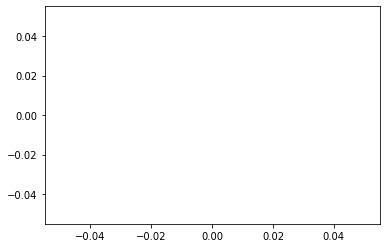

In [ ]:
plt.plot(los)

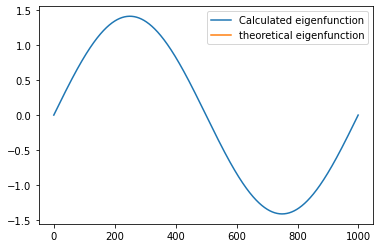

In [ ]:
import matplotlib.pyplot as plt
xx = jnp.linspace(0,1,1000)
xx = xx.reshape((1000,1))
y = batched_grad(params,xx)
z = batched_predict(params,xx)
y2 = batched_grad(params2,xx)
z2 = batched_predict(params2,xx)

# plt.plot(zz/jnp.sqrt(jnp.mean(zz**2)))
plt.plot(jnp.sin(2*jnp.pi*xx)*jnp.sqrt(2))
ss =(z2-z*jnp.mean(y2*y)/jnp.mean(y*y))
plt.plot(ss/jnp.sqrt(jnp.mean(ss**2)))
plt.legend(['Calculated eigenfunction','theoretical eigenfunction'])

Calculate the third eigenfunction
(note that the loss function only decrease after 4000 steps, so we increase the training epoches)

In [ ]:
params3 = init_network_params(layer_sizes, random.PRNGKey(0))
def loss3(params3,params2,params,x):
  y = batched_grad(params,x)
  z = batched_predict(params,x)
  y2p = batched_grad(params2,x)
  z2p = batched_predict(params2,x)
  y3 = batched_grad(params3,x)
  z3 = batched_predict(params3,x)
  y2 = y2p - jnp.mean(y2p*y)/jnp.mean(y*y)*y
  z2 = z2p-z*jnp.mean(y2p*y)/jnp.mean(y*y)

  dv = y3 - jnp.mean(y3*y)/jnp.mean(y*y)*y - jnp.mean(y3*y2)/jnp.mean(y2*y2)*y2
  v = jnp.mean((z3-z*jnp.mean(y3*y)/jnp.mean(y*y)-z2*jnp.mean(y3*y2)/jnp.mean(y2*y2))**2)

  return jnp.mean(dv**2)/v#(jnp.mean(y2*y2) - jnp.mean(y2*y)**2/jnp.mean(y*y))/sss #jnp.mean((y2 - y*jnp.mean(y2*y)/jnp.mean(y*y))**2)

In [ ]:
@jit
def update3(params3,params2,params, x):
  grads = grad(loss3)(params3,params2, params, x)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params3, grads)]


In [ ]:
los = []
for epoch in range(6000):
    x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
    for _ in range(1):
      params3 = update3(params3,params2, params, x)
    if epoch % 100==0:
      los.append(loss3(params3,params2,params,x))

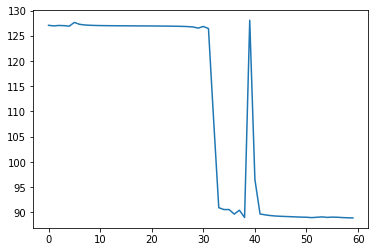

In [ ]:
plt.plot(los)

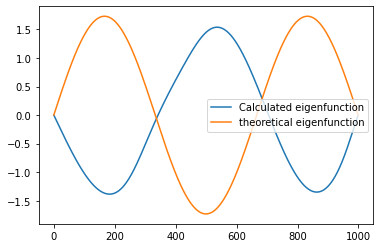

In [ ]:
import matplotlib.pyplot as plt
x = jnp.linspace(0,1,1000)
x = xx.reshape((1000,1))
y = batched_grad(params,x)
z = batched_predict(params,x)
y2p = batched_grad(params2,x)
z2p = batched_predict(params2,x)
y3 = batched_grad(params3,x)
z3 = batched_predict(params3,x)
y2 = y2p - jnp.mean(y2p*y)/jnp.mean(y*y)*y
z2 = z2p-z*jnp.mean(y2p*y)/jnp.mean(y*y)

s = y3 - jnp.mean(y3*y)/jnp.mean(y*y)*y - jnp.mean(y3*y2)/jnp.mean(y2*y2)*y2
ss = -(z3-z*jnp.mean(y3*y)/jnp.mean(y*y)-z2*jnp.mean(y3*y2)/jnp.mean(y2*y2))
plt.plot(ss/jnp.sqrt(jnp.mean(ss**2)))
plt.plot(jnp.sin(3*jnp.pi*xx)*jnp.sqrt(3))

plt.legend(['Calculated eigenfunction','theoretical eigenfunction'])

In [ ]:
los[-1]

Array(88.914246, dtype=float32)

In [ ]:
9*jnp.pi**2

88.82643960980423

Code To Continue Solving For Eigenvalues:


In [ ]:
num_eigs = 5
params_all = []
layer_sizes = [1, 256, 256, 1]
step_size = 1e-3
for i in range(num_eigs):
   params = init_network_params(layer_sizes, random.PRNGKey(0))
   params_all.append(params)


In [ ]:
def predict_one(params,x):
  return predict(params,x)[0]
batched_predict = vmap(predict_one, in_axes=(None, 0))
batched_grad = vmap(grad(predict_one,argnums=1), in_axes=(None, 0))


In [ ]:
batched_grad(params,x).shape

(1000, 1)

In [ ]:
def loss_i(params,params_other,x):
  yi = batched_grad(params,x)
  zi = batched_predict(params,x)
  y = [batched_grad(params_other[i],x) for i in range(len(params_other))]
  z = [batched_predict(params_other[i],x) for i in range(len(params_other))]
  y.append(yi)
  z.append(zi)
  print(len(y))
  y, z = y_to_v(y,z)
  return jnp.mean(y[-1]**2)/jnp.mean(z[-1]**2)

In [ ]:
# def loss_i(params,params_other,x):
#   yi = batched_grad(params,x)
#   zi = batched_predict(params,x)
#   dv = yi
#   v = zi
#   y = [batched_grad(params_other[i],x) for i in range(len(params_other))]
#   z = [batched_predict(params_other[i],x) for i in range(len(params_other))]
#   y, z = y_to_v(y,z)
#   for i in range(len(params_other)):
#     dv = dv - jnp.mean(yi*y[i])/jnp.mean(y[i]*y[i])*y[i]
#     v = v - jnp.mean(yi*y[i])/jnp.mean(y[i]*y[i])*z[i]
#   return jnp.mean(dv**2)/jnp.mean(v**2)





In [ ]:
def y_to_v(y,z):
  dv = []
  v = []

  for i in range(len(y)):
    yy=y[i]
    zz=z[i]
    for k in range(i):
      yy = yy - jnp.mean(y[i]*y[k])/jnp.mean(y[k]*y[k])*y[k]
      zz = zz - jnp.mean(y[i]*y[k])/jnp.mean(y[k]*y[k])*z[k]
    y[i]=yy
    z[i]=zz
    dv.append(yy)
    v.append(zz)
  return dv, v



In [ ]:
[[(i,k) for k in range(i)] for i in range(3)]

[[], [(1, 0)], [(2, 0), (2, 1)]]

In [ ]:
y = [batched_grad(params_all[i],x) for i in range(3)]
z = [batched_predict(params_all[i],x) for i in range(3)]
yy, zz = y_to_v(y,z)

In [ ]:
def compute_i(params,params_other,x):
  yi = batched_grad(params,x)
  zi = batched_predict(params,x)
  dv = yi
  v = zi
  y = [batched_grad(params_other[i],x) for i in range(len(params_other))]
  z = [batched_predict(params_other[i],x) for i in range(len(params_other))]
  y, z = y_to_v(y,z)
  for i in range(len(params_other)):
    dv = dv - jnp.mean(yi*y[i])/jnp.mean(y[i]*y[i])*y[i]
    v = v - jnp.mean(yi*y[i])/jnp.mean(y[i]*y[i])*z[i]
  return v





In [ ]:
@jit
def update_all(params, params_other, x):
  grads = grad(loss_i)(params, params_other, x)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


In [ ]:
tmp = [0,1,2]
tmp[:2]
tmp[2]

2

In [ ]:
for epoch in range(3000):
    x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
    for _ in range(1):
       params_all[0] = update_all(params_all[0],[], x)
       for j in range(num_eigs-1):
        params_all[j+1] = update_all(params_all[j+1],params_all[:(j+1)], x)

In [ ]:
# for epoch in range(10000):
#     x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
#     for _ in range(1):
#         j = 0
#         params_all[j+1] = update_all(params_all[j+1],params_all[:(j+1)], x)

In [ ]:
# for epoch in range(3000):
#     x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
#     for _ in range(1):
#         j = 2
#         params_all[j+1] = update_all(params_all[j+1],params_all[:(j+1)], x)

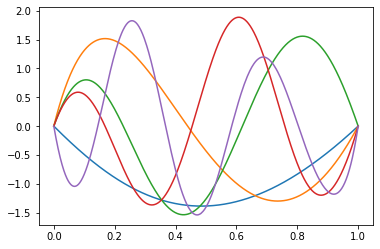

In [ ]:
import matplotlib.pyplot as plt
x = jnp.linspace(0,1,1000)
x = x.reshape((1000,1))
Y = [batched_grad(params_all[i],x) for i in range(num_eigs)]
Z = [batched_predict(params_all[i],x) for i in range(num_eigs)]
y, z = y_to_v(Y,Z)
# y1 = batched_grad(params_all[0],x)
# z1 = batched_predict(params_all[0],x)
# Z.append(z1)
# for j in range(num_eigs-1):
#   zj = compute_i(params_all[j+1],params_all[:(j+1)],x)
#   Z.append(zj)
for zz in z:
  plt.plot(x,zz/jnp.sqrt(jnp.mean(zz**2)))


In [ ]:
num_eigs = 2
params_all = []
layer_sizes = [1, 256, 256, num_eigs]
step_size = 1e-3
for i in range(num_eigs):
   params = init_network_params(layer_sizes, random.PRNGKey(0))
   params_all.append(params)


In [ ]:
params = init_network_params(layer_sizes, random.PRNGKey(0))


In [ ]:
zz=batched_predict(params,x)


In [ ]:
def predict_one(params,x):
  return predict(params,x)
batched_predict = vmap(predict_one, in_axes=(None, 0))
batched_grad = vmap(jacrev(predict_one,argnums=1), in_axes=(None, 0))


In [ ]:
y = batched_grad(params,x)[:,:,0]
z = batched_predict(params,x)

In [ ]:
from jax import jacfwd, jacrev


In [ ]:
y.shape[-1]

2

In [ ]:
def loss_all(params,x):
  y = batched_grad(params,x)[:,:,0]
  z = batched_predict(params,x)
  y,z = y_to_v(y,z)
  loss = 0
  for i in range(len(y)):
    loss += jnp.mean(y[i]**2)/jnp.mean(z[i]**2)
  return loss

In [ ]:
def y_to_v(y,z):
  dv = []
  v = []
  yp=[]
  zp=[]
  for i in range(y.shape[-1]):
    yy=y[:,i]
    zz=z[:,i]
    for k in range(i):
      yy = yy - jnp.mean(y[:,i]*yp[k])/jnp.mean(yp[k]*yp[k])*yp[k]
      zz = zz - jnp.mean(y[:,i]*yp[k])/jnp.mean(yp[k]*yp[k])*zp[k]
    yp.append(yy)
    zp.append(zz)
  return yp,zp



In [ ]:
@jit
def update_all(params, x):
  grads = grad(loss_all)(params, x)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


In [ ]:
for epoch in range(3000):
    x = random.uniform(random.PRNGKey(1),(1000,1),minval=0.,maxval=1.)
    for _ in range(1):
       params = update_all(params, x)


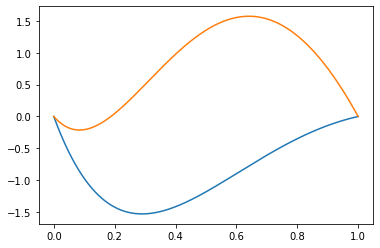

In [ ]:
import matplotlib.pyplot as plt
x = jnp.linspace(0,1,1000)
x = x.reshape((1000,1))
Y = batched_grad(params,x)[:,:,0]
Z = batched_predict(params,x)
y, z = y_to_v(Y,Z)
# y1 = batched_grad(params_all[0],x)
# z1 = batched_predict(params_all[0],x)
# Z.append(z1)
# for j in range(num_eigs-1):
#   zj = compute_i(params_all[j+1],params_all[:(j+1)],x)
#   Z.append(zj)
for zz in z:
  plt.plot(x,zz/jnp.sqrt(jnp.mean(zz**2)))


In [ ]:
z[0].shape

(1000,)